# Visualization Function Testing Notebook

This notebook tests the visualization functions `visualize_sample_slice` with configurable dataset and domain settings. It focuses on ground truth visualization and skips 3D visualization as requested.

## Features:
- Tests CHAOS and MMWHS datasets
- Supports CT and MR domains  
- Configurable visualization parameters
- Ground truth visualization testing
- Error handling and cleanup

In [1]:
"""
Test script for visualization functions.
Tests dataset.visualize_sample_slice with configurable dataset and domain.
Tests ground truth visualization only (3D visualization skipped).
"""

import torch
import numpy as np
from pathlib import Path
import sys

# Add src to path for imports
sys.path.append('src')

from src.datasets.registry import get_dataset
# Note: Using dataset.visualize_sample_slice() instead of standalone function

## Configuration

Change these constants to test different datasets and domains:
- **DATASET_NAME**: "CHAOS" or "MMWHS"
- **DOMAIN**: "CT" or "MR" 
- **ENCODER_TYPE**: "resnet" or "swin_unetr"
- **USE_SEMANTIC_HEAD**: Enable/disable semantic guidance

In [2]:
# Configuration constants
DATASET_NAME = "CHAOS"  # Change to "MMWHS" if needed
DOMAIN = "CT"          # Change to "CT" if needed
ENCODER_TYPE = "swin_unetr" # Change to "swin_unetr" if needed
USE_SEMANTIC_HEAD = False  # Set to True to test semantic head
BATCH_SIZE = 1
NUM_WORKERS = 0

print("🔧 Configuration:")
print(f"   Dataset: {DATASET_NAME}")
print(f"   Domain: {DOMAIN}")
print(f"   Encoder: {ENCODER_TYPE}")
print(f"   Use Semantic Head: {USE_SEMANTIC_HEAD}")

🔧 Configuration:
   Dataset: CHAOS
   Domain: CT
   Encoder: swin_unetr
   Use Semantic Head: False


## Ground Truth Visualization Testing

This section loads the dataset and tests the `visualize_sample_slice` function with ground truth data.

In [3]:
def test_ground_truth_visualization():
    """Test visualization functions with ground truth data."""
    print("🔍 Testing Ground Truth Visualization...")
    print(f"Dataset: {DATASET_NAME}, Domain: {DOMAIN}")

    # Load dataset
    dataset = get_dataset(
        dataset_name=DATASET_NAME,
        domain=DOMAIN,
        base_path=Path('data'),
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        slice_2d=False  # Use 3D data
    )

    # Get a sample from the dataset
    loader = dataset.train_loader
    batch = next(iter(loader))

    # Extract a single sample
    sample = {
        'image': batch['image'],  # Remove batch dimension
        'label': batch['label']   # Remove batch dimension
    }

    print(f"Sample image shape: {sample['image'].shape}")
    print(f"Sample label shape: {sample['label'].shape}")

    return dataset, sample

def test_inference():
    # Load dataset
    dataset = get_dataset(
        dataset_name=DATASET_NAME,
        domain=DOMAIN,
        base_path=Path('data'),
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        slice_2d=False  # Use 3D data
    )

    # Get a sample from the dataset
    loader = dataset.train_loader
    batch = next(iter(loader))

    model = dataset.get_hybrid_model(encoder_type=ENCODER_TYPE, use_semantic_head=USE_SEMANTIC_HEAD)
    outputs = model(batch['image'])
    preds = torch.argmax(outputs, dim=1, keepdim=True)

    # Extract a single sample
    sample = {
        'image': batch['image'],  # Remove batch dimension
        'label': preds
    }

    print(f"Sample image shape: {sample['image'].shape}")
    print(f"Pred label shape: {preds.shape}")

    return dataset, sample

In [4]:
# Run ground truth visualization test
try:
    dataset, sample = test_ground_truth_visualization()
    print("✅ Dataset loaded successfully!")
except Exception as e:
    print(f"❌ Error loading dataset: {e}")
    import traceback
    traceback.print_exc()

🔍 Testing Ground Truth Visualization...
Dataset: CHAOS, Domain: CT


Sample image shape: torch.Size([1, 1, 101, 512, 512])
Sample label shape: torch.Size([1, 1, 101, 512, 512])
✅ Dataset loaded successfully!


## Dataset Visualization Method Test

Test the `dataset.visualize_sample_slice()` method with the loaded ground truth data. This uses the dataset-specific implementation which automatically applies the correct rotation and flip parameters for each dataset type.


📊 Testing dataset.visualize_sample_slice method...
Flipping along axes: (1,)
Flipping along axis 1


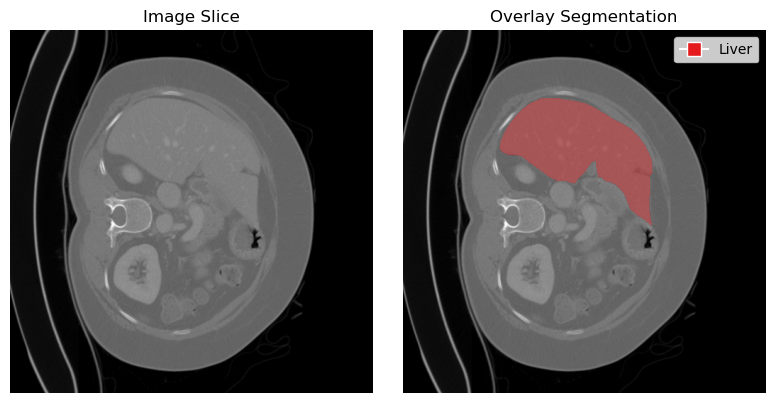

[0 1]
✅ Dataset visualization method completed successfully!


In [5]:
## Dataset Visualization Method Test

# Test dataset.visualize_sample_slice method
print("\n📊 Testing dataset.visualize_sample_slice method...")
# Squeeze batch and channel dimensions for visualization
sample['image'] = sample['image'].squeeze().permute(2, 1, 0).cpu().numpy()
sample['label'] = sample['label'].squeeze().permute(2, 1, 0).cpu().numpy()
# Use the dataset method instead of standalone function
dataset.visualize_sample_slice(sample)

print(np.unique(sample['label']))

print("✅ Dataset visualization method completed successfully!")

In [ ]:
dataset, sample = test_inference()
sample['image'] = sample['image'].squeeze().permute(2, 1, 0).cpu().numpy()
sample['label'] = 63*sample['label'].squeeze().permute(2, 1, 0).cpu().numpy()
print(np.unique(sample['label']))
dataset.visualize_sample_slice(sample)

2025-07-07 15:56:20,968 - INFO - Expected md5 is None, skip md5 check for file ssl_pretrained_weights.pth.
2025-07-07 15:56:20,972 - INFO - File exists: ssl_pretrained_weights.pth, skipped downloading.
Error loading SwinViT weights: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.
